# Why Deep Learning Works: A Geometric Intuition

## Understanding Neural Networks Through Space Folding

---

**Welcome!** This notebook will give you a deep geometric understanding of why neural networks work. We'll visualize how networks learn complex patterns by **folding and bending space** - an insight that makes deep learning suddenly make sense!

Based on the brilliant [Welch Labs video](https://www.youtube.com/watch?v=qx7hirqgfuU).

---

## The Big Question

> **Why do DEEP networks work so much better than WIDE networks?**

We'll answer this through hands-on visualizations!

---

## What You'll Learn

```
┌─────────────────────────────────────────────────────────────────────────┐
│                        OUR JOURNEY                                      │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  1. THE CHALLENGE                                                       │
│     └── A complex border that's hard to classify                        │
│                                                                         │
│  2. LINEAR LIMITS                                                       │
│     └── Why single neurons can only draw straight lines                 │
│                                                                         │
│  3. THE FOLDING INSIGHT                                                 │
│     └── How ReLU bends and folds space ← KEY INSIGHT!                   │
│                                                                         │
│  4. WIDE vs DEEP                                                        │
│     └── Why 5 layers × 32 neurons beats 100,000 neurons × 1 layer       │
│                                                                         │
│  5. THE PROOF                                                           │
│     └── Watch deep networks succeed where shallow ones fail             │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
```

## Visual Overview: The Core Insight

```
                    WHY DEEP BEATS WIDE
                    
    SHALLOW NETWORK (Wide)              DEEP NETWORK (Narrow)
    ═══════════════════════             ═══════════════════════
    
         ●●●●●●●●●●●●                        ●●●●
         ↓↓↓↓↓↓↓↓↓↓↓↓                        ↓↓↓↓
              ●                            ●●●●
                                           ↓↓↓↓
    100,000 neurons                        ●●●●
    1 hidden layer                         ↓↓↓↓
                                           ●●●●
                                           ↓↓↓↓
                                           ●●●●
                                           ↓↓↓↓
                                            ●
                                           
                                    32 neurons × 5 layers
                                    = 160 neurons total!
    
    Result: STRUGGLES!              Result: SUCCEEDS!
    
    
    WHY? Because depth creates EXPONENTIALLY more decision regions!
    
    Wide:  Regions grow LINEARLY with neurons
    Deep:  Regions grow EXPONENTIALLY with layers
```

## Setup

Let's import everything we need.

In [ ]:
# Install dependencies (uncomment if in Colab)
# !pip install torch numpy matplotlib scikit-learn --quiet

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

# For neural network training
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False
    print("PyTorch not available. Some demos will use NumPy implementations.")

# Beautiful plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 11

# Reproducibility
np.random.seed(42)
if TORCH_AVAILABLE:
    torch.manual_seed(42)

print("✅ Setup complete!")
print(f"   PyTorch available: {TORCH_AVAILABLE}")

✅ Setup complete!
   PyTorch available: True


---

# Part 1: The Universal Approximation Theorem

## The Promise (and the Problem)

There's a beautiful theorem in mathematics:

> **Universal Approximation Theorem**: A neural network with just ONE hidden layer can approximate ANY continuous function, given enough neurons.

This sounds amazing! It means that theoretically, we never need deep networks - a single wide layer should be enough.

**But here's the catch...**

```
╔══════════════════════════════════════════════════════════════════════════╗
║                    THE UNIVERSAL APPROXIMATION TRAP                       ║
╠══════════════════════════════════════════════════════════════════════════╣
║                                                                           ║
║   The theorem says: "A solution EXISTS"                                  ║
║                                                                           ║
║   It does NOT say: "You can FIND it easily"                              ║
║                                                                           ║
║   It does NOT say: "It will be EFFICIENT"                                ║
║                                                                           ║
║   In practice:                                                            ║
║   • May need BILLIONS of neurons                                          ║
║   • Training might never converge                                         ║
║   • Gradient descent gets stuck                                           ║
║                                                                           ║
╚══════════════════════════════════════════════════════════════════════════╝
```

Let's see this in action!

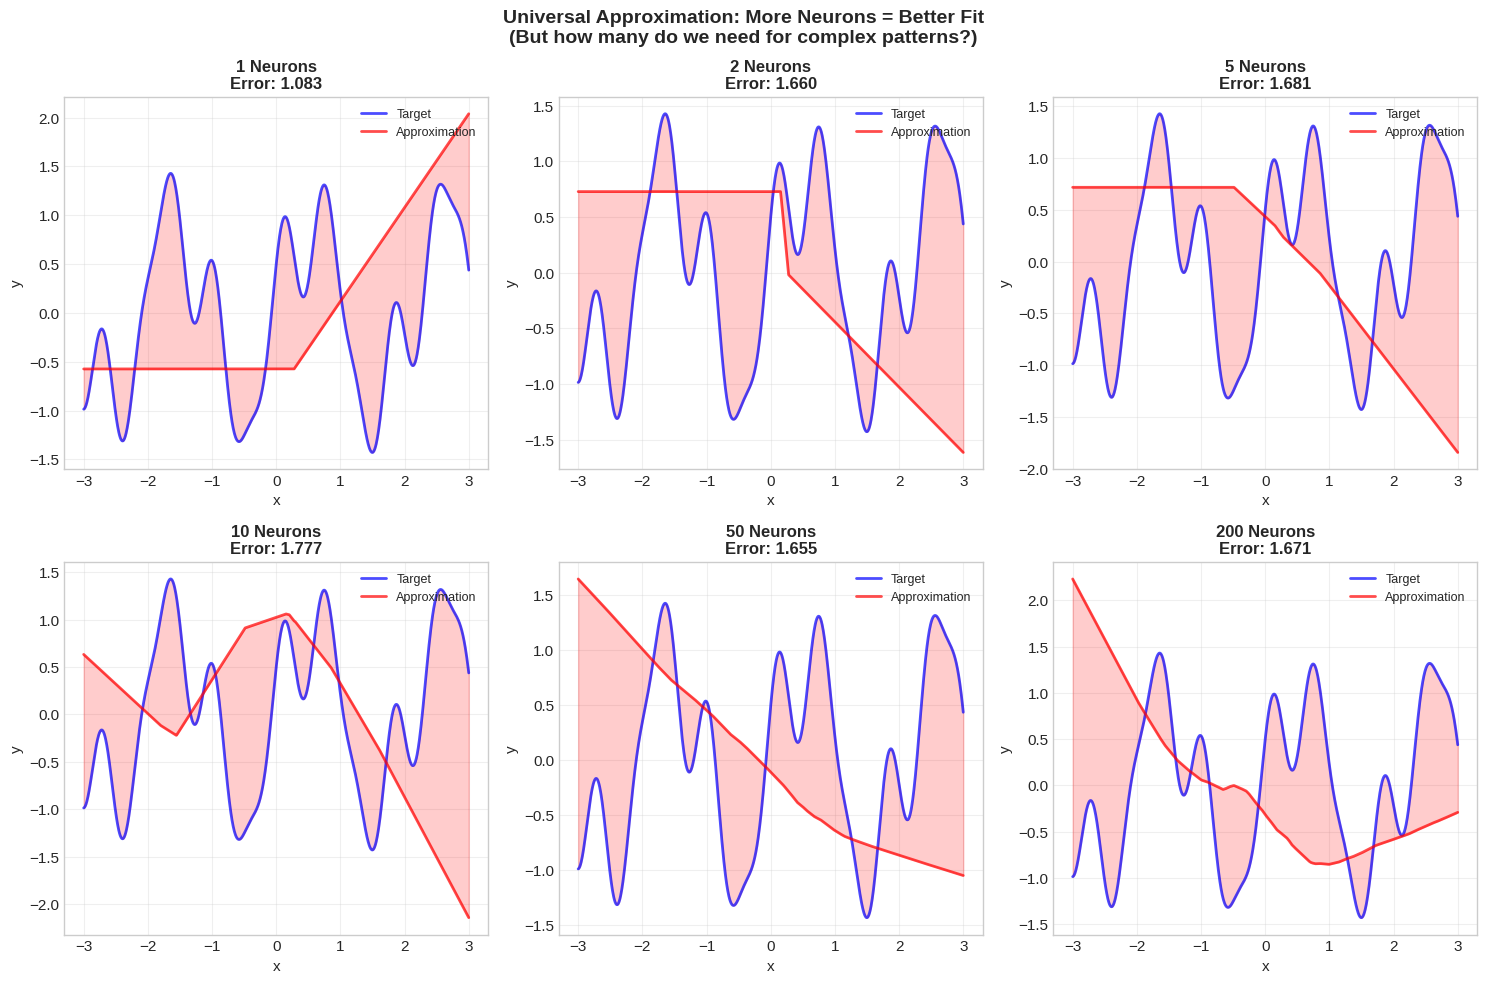


💡 Key Insight: Yes, we CAN approximate any function...
   But for complex patterns, we might need MILLIONS of neurons!
   Is there a better way? (Spoiler: YES - go DEEP!)


In [ ]:
def visualize_universal_approximation():
    """
    Visualize the Universal Approximation Theorem.

    Shows how a wide network CAN approximate a function,
    but might need MANY neurons.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Target function: a complex wiggly curve
    x = np.linspace(-3, 3, 1000)
    y_target = np.sin(3*x) + 0.5*np.cos(7*x) + 0.3*np.sin(11*x)

    neuron_counts = [1, 2, 5, 10, 50, 200]

    for ax, n_neurons in zip(axes.flat, neuron_counts):
        # Simulate what n_neurons could approximate
        # (simplified: using random ReLU bumps)
        np.random.seed(42)
        y_approx = np.zeros_like(x)

        for i in range(n_neurons):
            # Random neuron: ReLU(w*x + b) with random weight
            w = np.random.randn() * 2
            b = np.random.randn() * 2
            weight = np.random.randn() * 0.5
            relu_out = np.maximum(0, w * x + b)
            y_approx += weight * relu_out / np.sqrt(n_neurons)

        # Scale to match target roughly
        y_approx = y_approx * (y_target.std() / (y_approx.std() + 1e-8))
        y_approx = y_approx - y_approx.mean() + y_target.mean()

        ax.plot(x, y_target, 'b-', linewidth=2, label='Target', alpha=0.7)
        ax.plot(x, y_approx, 'r-', linewidth=2, label='Approximation', alpha=0.7)
        ax.fill_between(x, y_target, y_approx, alpha=0.2, color='red')

        error = np.mean((y_target - y_approx)**2)
        ax.set_title(f'{n_neurons} Neurons\nError: {error:.3f}', fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)

    fig.suptitle('Universal Approximation: More Neurons = Better Fit\n(But how many do we need for complex patterns?)',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_universal_approximation()

print("\n💡 Key Insight: Yes, we CAN approximate any function...")
print("   But for complex patterns, we might need MILLIONS of neurons!")
print("   Is there a better way? (Spoiler: YES - go DEEP!)")

---

# Part 2: The Challenge - A Complex Border

## The Belgium-Netherlands Border Problem

To really understand why depth matters, we need a **challenging classification problem**.

The video uses the border between Belgium and the Netherlands - a famously complex, wiggly line that's hard to separate.

Let's create our own version of this challenge!

```
    THE CLASSIFICATION CHALLENGE
    
    We want to separate two classes:
    🔵 Blue points (Class 0)
    🔴 Red points (Class 1)
    
    The border between them is VERY wiggly!
    
    ┌────────────────────────────────┐
    │🔵🔵🔵🔵🔵                       │
    │    🔵🔵🔵🔴🔴🔴                 │
    │        ~~~🔴🔴🔴🔴              │
    │     🔵🔵🔵~~~~~🔴🔴            │
    │  🔵🔵🔵     ~~~🔴🔴🔴🔴🔴       │
    │🔵🔵🔵🔵🔵🔵~~~~🔴🔴🔴🔴🔴🔴     │
    └────────────────────────────────┘
    
    Can a neural network learn this border?
```

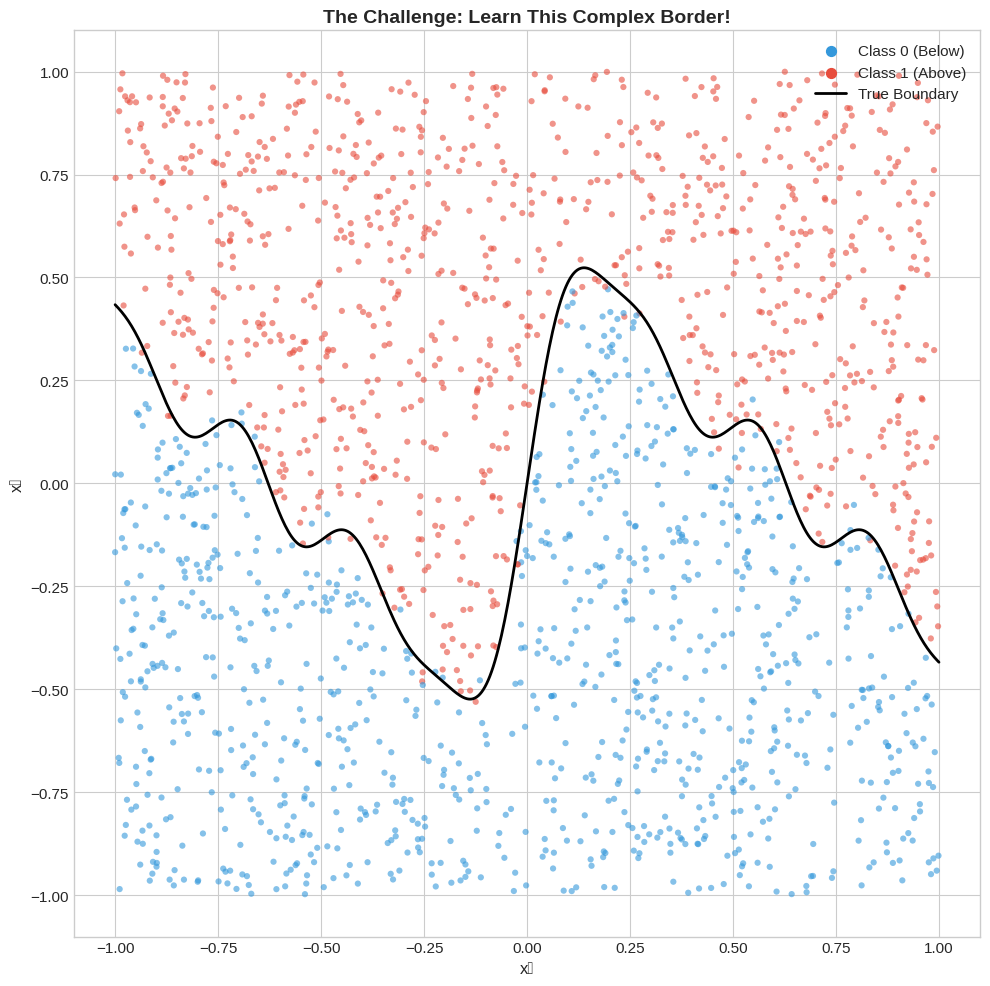


🎯 THE CHALLENGE:
   • 2000 data points
   • 2 classes separated by a VERY wiggly boundary
   • Can a neural network learn to separate them?

   Let's find out!


In [ ]:
def create_complex_border_dataset(n_samples: int = 2000, noise: float = 0.05):
    """
    Create a dataset with a complex, wiggly decision boundary.

    This mimics the Belgium-Netherlands border challenge from the video.

    Args:
        n_samples: Number of points to generate
        noise: Amount of noise to add

    Returns:
        X: Points (n_samples, 2)
        y: Labels (n_samples,)
    """
    np.random.seed(42)

    # Generate random points in a square
    X = np.random.rand(n_samples, 2) * 2 - 1  # Range [-1, 1]

    # Create a complex, wiggly boundary
    # Boundary: y = 0.5*sin(5x) + 0.3*sin(10x) + 0.1*sin(20x)
    boundary = (
        0.4 * np.sin(5 * X[:, 0]) +
        0.2 * np.sin(10 * X[:, 0]) +
        0.1 * np.sin(15 * X[:, 0]) +
        0.05 * np.sin(25 * X[:, 0])
    )

    # Add some noise to make it harder
    boundary += np.random.randn(n_samples) * noise

    # Classify based on position relative to boundary
    y = (X[:, 1] > boundary).astype(int)

    return X, y

def plot_dataset(X, y, title="Dataset", ax=None, show_boundary=True):
    """
    Visualize the dataset with its true decision boundary.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Custom colormap
    colors = ['#3498db', '#e74c3c']  # Blue and Red

    # Plot points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors),
                        s=20, alpha=0.6, edgecolors='none')

    if show_boundary:
        # Plot true boundary
        x_line = np.linspace(-1, 1, 500)
        y_boundary = (
            0.4 * np.sin(5 * x_line) +
            0.2 * np.sin(10 * x_line) +
            0.1 * np.sin(15 * x_line) +
            0.05 * np.sin(25 * x_line)
        )
        ax.plot(x_line, y_boundary, 'k-', linewidth=2, label='True Boundary')

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel('x₁', fontsize=12)
    ax.set_ylabel('x₂', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_aspect('equal')

    # Legend
    legend_elements = [
        plt.scatter([], [], c=colors[0], s=50, label='Class 0 (Below)'),
        plt.scatter([], [], c=colors[1], s=50, label='Class 1 (Above)'),
    ]
    if show_boundary:
        legend_elements.append(plt.Line2D([0], [0], color='black', linewidth=2, label='True Boundary'))
    ax.legend(handles=legend_elements, loc='upper right')

    return ax

# Create and visualize our dataset
X_train, y_train = create_complex_border_dataset(n_samples=2000)

fig, ax = plt.subplots(figsize=(12, 10))
plot_dataset(X_train, y_train, "The Challenge: Learn This Complex Border!", ax)
plt.tight_layout()
plt.show()

print("\n🎯 THE CHALLENGE:")
print(f"   • {len(X_train)} data points")
print(f"   • 2 classes separated by a VERY wiggly boundary")
print(f"   • Can a neural network learn to separate them?")
print("\n   Let's find out!")

---

# Part 3: What a Single Neuron Can Do

## Linear Decision Boundaries

Before understanding deep networks, let's see what a **single neuron** can do.

A single neuron computes:
$$z = w_1 x_1 + w_2 x_2 + b$$

And classifies based on whether $z > 0$ or $z < 0$.

```
        WHAT ONE NEURON SEES
        
        x₂
        │      Class 1
        │        /
        │       /
        │      /    ← This is a STRAIGHT LINE!
        │     /
        │    /  Class 0
        │   /
        └──/─────────── x₁
        
        One neuron = One straight line
        Can't handle wiggly boundaries! 😢
```

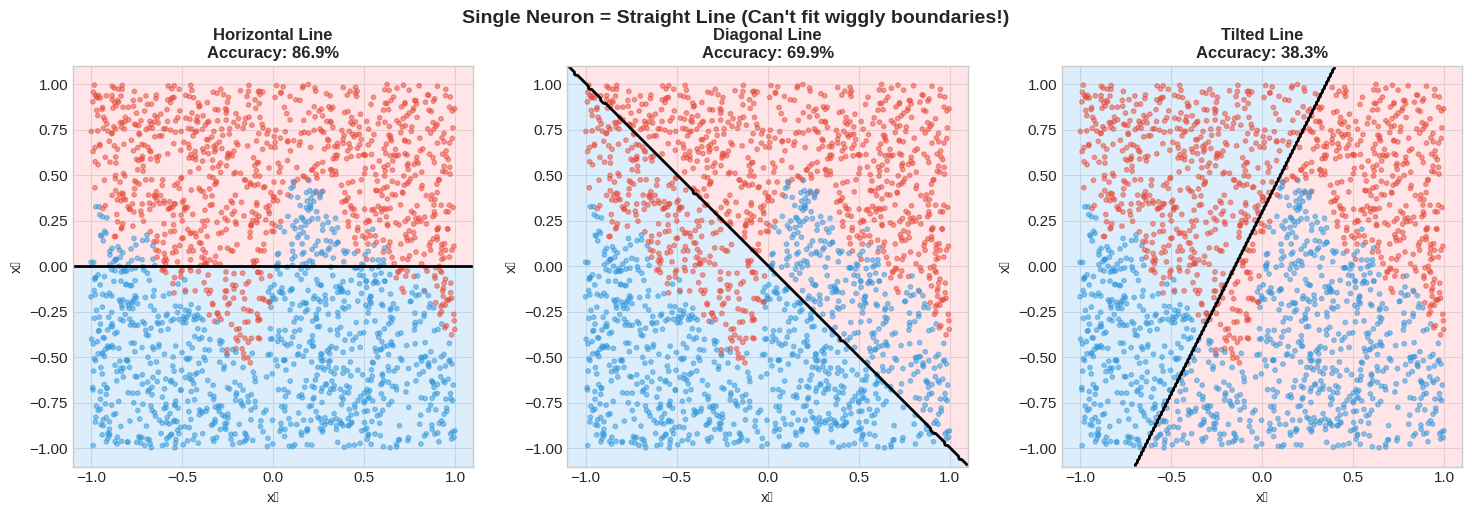


❌ PROBLEM: A single neuron can only draw STRAIGHT LINES!
   No matter how we rotate or shift the line, we can't fit the wiggly border.

   We need something more powerful...


In [ ]:
def visualize_linear_classifier():
    """
    Show that a single neuron can only create linear boundaries.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Create mesh for decision boundary visualization
    xx, yy = np.meshgrid(np.linspace(-1.1, 1.1, 200),
                         np.linspace(-1.1, 1.1, 200))

    # Different linear classifiers
    classifiers = [
        {'w1': 0, 'w2': 1, 'b': 0, 'name': 'Horizontal Line'},
        {'w1': 1, 'w2': 1, 'b': 0, 'name': 'Diagonal Line'},
        {'w1': 2, 'w2': -1, 'b': 0.3, 'name': 'Tilted Line'},
    ]

    colors = ['#3498db', '#e74c3c']

    for ax, clf in zip(axes, classifiers):
        # Compute decision boundary
        Z = clf['w1'] * xx + clf['w2'] * yy + clf['b']
        Z = (Z > 0).astype(int)

        # Plot decision regions
        ax.contourf(xx, yy, Z, cmap=ListedColormap(['#bbdefb', '#ffcdd2']), alpha=0.5)
        ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

        # Plot data
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                  cmap=ListedColormap(colors), s=10, alpha=0.5)

        # Calculate accuracy
        pred = (clf['w1'] * X_train[:, 0] + clf['w2'] * X_train[:, 1] + clf['b'] > 0).astype(int)
        acc = (pred == y_train).mean() * 100

        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_title(f"{clf['name']}\nAccuracy: {acc:.1f}%", fontsize=12, fontweight='bold')
        ax.set_xlabel('x₁')
        ax.set_ylabel('x₂')
        ax.set_aspect('equal')

    fig.suptitle('Single Neuron = Straight Line (Can\'t fit wiggly boundaries!)',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_linear_classifier()

print("\n❌ PROBLEM: A single neuron can only draw STRAIGHT LINES!")
print("   No matter how we rotate or shift the line, we can't fit the wiggly border.")
print("\n   We need something more powerful...")

---

# Part 4: The Magic of Activation Functions

## How ReLU "Folds" Space

This is the **KEY INSIGHT** of the video!

The **ReLU** (Rectified Linear Unit) activation function does something magical:

$$\text{ReLU}(x) = \max(0, x)$$

It looks simple, but it has a profound effect: **it folds space!**

```
        THE RELU FUNCTION
        
        output
        │         /
        │        /
        │       /
        │      /
        │     /
        ─────●──────────── input
             0
        
        • Negative inputs → 0 (squashed flat)
        • Positive inputs → unchanged (linear)
        
        This creates a "FOLD" or "BEND" in the space!
```

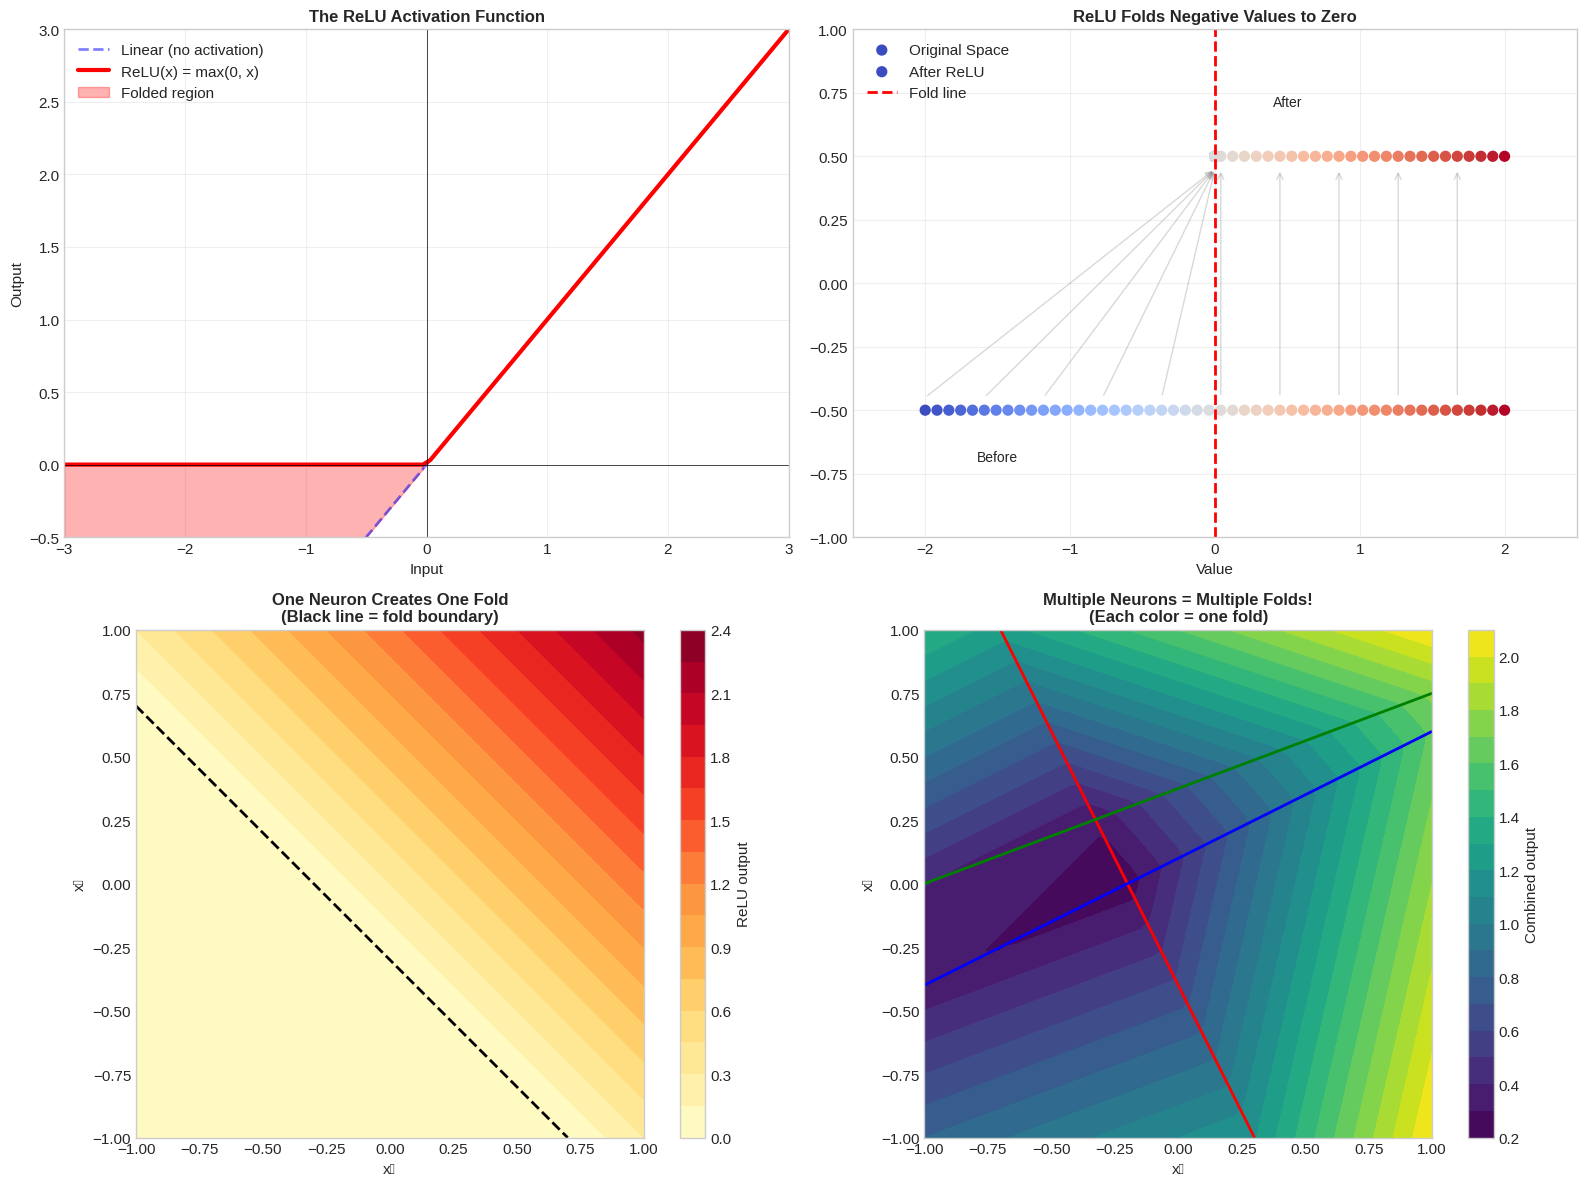


🔑 KEY INSIGHT: Each ReLU neuron creates ONE fold in the input space!
   • More neurons = More folds = More complex boundaries
   • But wait... there's something even MORE powerful...


In [ ]:
def visualize_relu_folding():
    """
    Visualize how ReLU creates folds in space.
    """
    fig = plt.figure(figsize=(16, 12))

    # 1. The ReLU function itself
    ax1 = fig.add_subplot(2, 2, 1)
    x = np.linspace(-3, 3, 100)
    relu = np.maximum(0, x)

    ax1.plot(x, x, 'b--', linewidth=2, label='Linear (no activation)', alpha=0.5)
    ax1.plot(x, relu, 'r-', linewidth=3, label='ReLU(x) = max(0, x)')
    ax1.axhline(y=0, color='k', linewidth=0.5)
    ax1.axvline(x=0, color='k', linewidth=0.5)
    ax1.fill_between(x[x<0], 0, x[x<0], alpha=0.3, color='red', label='Folded region')
    ax1.set_xlabel('Input', fontsize=11)
    ax1.set_ylabel('Output', fontsize=11)
    ax1.set_title('The ReLU Activation Function', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-3, 3)
    ax1.set_ylim(-0.5, 3)

    # 2. 1D folding visualization
    ax2 = fig.add_subplot(2, 2, 2)

    # Original space
    x_orig = np.linspace(-2, 2, 50)
    y_orig = np.zeros_like(x_orig)
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(x_orig)))

    ax2.scatter(x_orig, y_orig - 0.5, c=colors, s=50, label='Original Space')
    ax2.scatter(np.maximum(0, x_orig), y_orig + 0.5, c=colors, s=50, label='After ReLU')

    # Show the folding with arrows
    for i in range(0, len(x_orig), 5):
        ax2.annotate('', xy=(np.maximum(0, x_orig[i]), 0.45),
                    xytext=(x_orig[i], -0.45),
                    arrowprops=dict(arrowstyle='->', color='gray', alpha=0.3))

    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Fold line')
    ax2.set_xlim(-2.5, 2.5)
    ax2.set_ylim(-1, 1)
    ax2.set_title('ReLU Folds Negative Values to Zero', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.set_xlabel('Value')
    ax2.text(-1.5, -0.7, 'Before', fontsize=10, ha='center')
    ax2.text(0.5, 0.7, 'After', fontsize=10, ha='center')
    ax2.grid(True, alpha=0.3)

    # 3. 2D space folding - single neuron
    ax3 = fig.add_subplot(2, 2, 3)

    # Create 2D grid
    xx, yy = np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50))

    # Single neuron: z = w1*x + w2*y + b
    w1, w2, b = 1, 1, 0.3
    z = w1 * xx + w2 * yy + b
    z_relu = np.maximum(0, z)

    # Show the fold
    im = ax3.contourf(xx, yy, z_relu, levels=20, cmap='YlOrRd')
    ax3.contour(xx, yy, z, levels=[0], colors='black', linewidths=2, linestyles='--')
    ax3.set_title('One Neuron Creates One Fold\n(Black line = fold boundary)',
                 fontsize=12, fontweight='bold')
    ax3.set_xlabel('x₁')
    ax3.set_ylabel('x₂')
    ax3.set_aspect('equal')
    plt.colorbar(im, ax=ax3, label='ReLU output')

    # 4. Multiple neurons = multiple folds
    ax4 = fig.add_subplot(2, 2, 4)

    # Three neurons with different orientations
    z1 = np.maximum(0, 1*xx + 0.5*yy + 0.2)
    z2 = np.maximum(0, -0.5*xx + 1*yy - 0.1)
    z3 = np.maximum(0, 0.3*xx - 0.8*yy + 0.3)
    z_combined = z1 + z2 + z3

    im = ax4.contourf(xx, yy, z_combined, levels=20, cmap='viridis')
    # Show fold lines
    ax4.contour(xx, yy, 1*xx + 0.5*yy + 0.2, levels=[0], colors='red', linewidths=2)
    ax4.contour(xx, yy, -0.5*xx + 1*yy - 0.1, levels=[0], colors='blue', linewidths=2)
    ax4.contour(xx, yy, 0.3*xx - 0.8*yy + 0.3, levels=[0], colors='green', linewidths=2)
    ax4.set_title('Multiple Neurons = Multiple Folds!\n(Each color = one fold)',
                 fontsize=12, fontweight='bold')
    ax4.set_xlabel('x₁')
    ax4.set_ylabel('x₂')
    ax4.set_aspect('equal')
    plt.colorbar(im, ax=ax4, label='Combined output')

    plt.tight_layout()
    plt.show()

visualize_relu_folding()

print("\n🔑 KEY INSIGHT: Each ReLU neuron creates ONE fold in the input space!")
print("   • More neurons = More folds = More complex boundaries")
print("   • But wait... there's something even MORE powerful...")

---

# Part 5: The Power of Depth - Exponential Regions

## Wide vs Deep: The Key Comparison

Here's where it gets exciting! Adding neurons in **width** vs **depth** has very different effects:

```
╔══════════════════════════════════════════════════════════════════════════════╗
║                       WIDE vs DEEP: THE MATH                                  ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                               ║
║   WIDE (add neurons to one layer):                                           ║
║   ─────────────────────────────────                                          ║
║   Each neuron adds ONE fold                                                  ║
║   n neurons → n folds → roughly n+1 regions                                  ║
║                                                                               ║
║   Regions grow LINEARLY: O(n)                                                ║
║                                                                               ║
║   ─────────────────────────────────────────────────────────────────────────  ║
║                                                                               ║
║   DEEP (add layers):                                                         ║
║   ─────────────────────────────────                                          ║
║   Each layer MULTIPLIES the complexity!                                      ║
║   Previous folds get folded again!                                           ║
║                                                                               ║
║   With n neurons per layer and L layers:                                     ║
║   Regions can grow up to O(n^L) - EXPONENTIAL!                               ║
║                                                                               ║
║   Example:                                                                    ║
║   • Wide: 100 neurons × 1 layer = ~100 regions                               ║
║   • Deep: 10 neurons × 5 layers = up to 10^5 = 100,000 regions!              ║
║                                                                               ║
╚══════════════════════════════════════════════════════════════════════════════╝
```

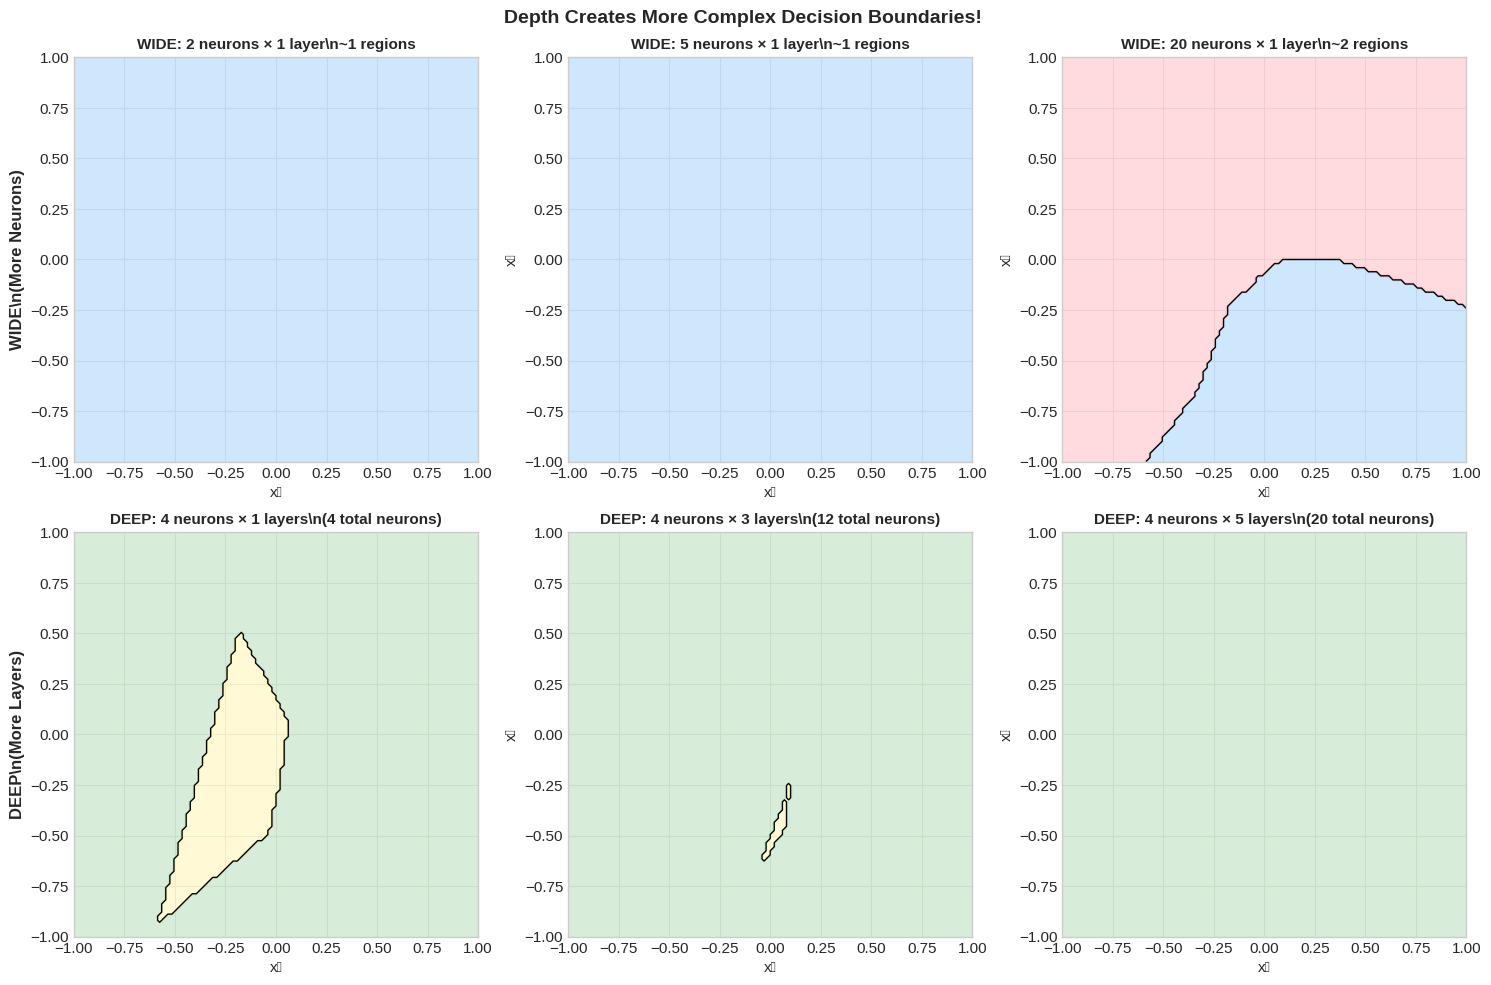

\n📊 OBSERVATION:
   • WIDE: Adding neurons creates more parallel folds
   • DEEP: Adding layers creates HIERARCHICAL folds (folds on folds!)
\n   The deep network with FEWER total neurons creates MORE complex regions!


In [ ]:
def visualize_depth_vs_width():
    """
    Visualize how depth creates exponentially more regions than width.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Create grid
    xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    np.random.seed(42)

    # Row 1: Wide networks (increasing neurons in one layer)
    for idx, n_neurons in enumerate([2, 5, 20]):
        ax = axes[0, idx]

        # Simulate a wide network with n_neurons
        output = np.zeros(len(grid))
        for i in range(n_neurons):
            w1 = np.random.randn() * 2
            w2 = np.random.randn() * 2
            b = np.random.randn() * 0.5
            weight = np.random.randn()
            z = w1 * grid[:, 0] + w2 * grid[:, 1] + b
            output += weight * np.maximum(0, z)

        Z = (output > 0).astype(int).reshape(xx.shape)

        ax.contourf(xx, yy, Z, cmap=ListedColormap(['#bbdefb', '#ffcdd2']), alpha=0.7)
        ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=1)

        # Count regions (approximate)
        unique_regions = len(np.unique(Z.ravel()))
        ax.set_title(f'WIDE: {n_neurons} neurons × 1 layer\\n~{unique_regions} regions',
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('x₁')
        ax.set_ylabel('x₂')
        ax.set_aspect('equal')

    # Row 2: Deep networks (increasing layers)
    for idx, n_layers in enumerate([1, 3, 5]):
        ax = axes[1, idx]

        # Simulate a deep network with n_layers
        neurons_per_layer = 4

        # Start with input
        layer_input = grid.copy()

        for layer in range(n_layers):
            np.random.seed(42 + layer)
            layer_output = np.zeros((len(grid), neurons_per_layer))

            for i in range(neurons_per_layer):
                w = np.random.randn(layer_input.shape[1]) * 2
                b = np.random.randn() * 0.5
                z = layer_input @ w + b
                layer_output[:, i] = np.maximum(0, z)

            layer_input = layer_output

        # Final output
        final_w = np.random.randn(neurons_per_layer)
        output = layer_input @ final_w

        Z = (output > 0).astype(int).reshape(xx.shape)

        ax.contourf(xx, yy, Z, cmap=ListedColormap(['#c8e6c9', '#fff9c4']), alpha=0.7)
        ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=1)

        total_neurons = neurons_per_layer * n_layers
        ax.set_title(f'DEEP: {neurons_per_layer} neurons × {n_layers} layers\\n({total_neurons} total neurons)',
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('x₁')
        ax.set_ylabel('x₂')
        ax.set_aspect('equal')

    axes[0, 0].set_ylabel('WIDE\\n(More Neurons)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('DEEP\\n(More Layers)', fontsize=12, fontweight='bold')

    fig.suptitle('Depth Creates More Complex Decision Boundaries!', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_depth_vs_width()

print("\\n📊 OBSERVATION:")
print("   • WIDE: Adding neurons creates more parallel folds")
print("   • DEEP: Adding layers creates HIERARCHICAL folds (folds on folds!)")
print("\\n   The deep network with FEWER total neurons creates MORE complex regions!")

---

# Part 6: The Proof - Training Real Networks

## Let's Put It to the Test!

Now for the moment of truth. We'll train two networks on our complex border:

```
    EXPERIMENT SETUP
    ════════════════
    
    Network A: SHALLOW & WIDE
    ─────────────────────────
    • 1 hidden layer
    • 1000 neurons
    • Total: ~1000 parameters
    
    vs
    
    Network B: DEEP & NARROW  
    ─────────────────────────
    • 5 hidden layers
    • 32 neurons each
    • Total: ~160 neurons
    
    
    Which one will learn the wiggly border better?
```

Let's find out!

In [ ]:
if TORCH_AVAILABLE:

    class ShallowNetwork(nn.Module):
        """A wide, shallow network (1 hidden layer, many neurons)."""

        def __init__(self, hidden_size=1000):
            super().__init__()
            self.fc1 = nn.Linear(2, hidden_size)
            self.fc2 = nn.Linear(hidden_size, 1)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.sigmoid(self.fc2(x))
            return x

    class DeepNetwork(nn.Module):
        """A narrow, deep network (5 hidden layers, fewer neurons each)."""

        def __init__(self, hidden_size=32, n_layers=5):
            super().__init__()

            layers = [nn.Linear(2, hidden_size), nn.ReLU()]
            for _ in range(n_layers - 1):
                layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
            layers.append(nn.Linear(hidden_size, 1))
            layers.append(nn.Sigmoid())

            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    def count_parameters(model):
        """Count trainable parameters in a model."""
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    def train_network(model, X, y, epochs=500, lr=0.01, verbose=True):
        """Train a neural network and return loss history."""

        # Convert to tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y).reshape(-1, 1)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCELoss()

        losses = []
        accuracies = []

        for epoch in range(epochs):
            # Forward pass
            outputs = model(X_tensor)
            loss = criterion(outputs, y_tensor)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            losses.append(loss.item())
            predictions = (outputs > 0.5).float()
            accuracy = (predictions == y_tensor).float().mean().item()
            accuracies.append(accuracy)

            if verbose and (epoch + 1) % 100 == 0:
                print(f"   Epoch {epoch+1}/{epochs}: Loss={loss.item():.4f}, Accuracy={accuracy*100:.1f}%")

        return losses, accuracies

    def plot_decision_boundary(model, X, y, title, ax):
        """Plot the decision boundary learned by a network."""

        # Create mesh
        xx, yy = np.meshgrid(np.linspace(-1.1, 1.1, 200),
                           np.linspace(-1.1, 1.1, 200))
        grid = np.c_[xx.ravel(), yy.ravel()]
        grid_tensor = torch.FloatTensor(grid)

        # Get predictions
        with torch.no_grad():
            Z = model(grid_tensor).numpy().reshape(xx.shape)

        # Plot
        colors = ['#3498db', '#e74c3c']
        ax.contourf(xx, yy, Z, levels=np.linspace(0, 1, 11), cmap='RdBu_r', alpha=0.7)
        ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors), s=10, alpha=0.5)

        # True boundary
        x_line = np.linspace(-1, 1, 500)
        y_boundary = (0.4 * np.sin(5 * x_line) + 0.2 * np.sin(10 * x_line) +
                     0.1 * np.sin(15 * x_line) + 0.05 * np.sin(25 * x_line))
        ax.plot(x_line, y_boundary, 'g--', linewidth=2, label='True Boundary')

        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('x₁')
        ax.set_ylabel('x₂')
        ax.set_aspect('equal')
        ax.legend(loc='upper right')

    print("✅ Neural network classes defined!")
    print("\\n📊 Network Comparison:")

    shallow = ShallowNetwork(hidden_size=1000)
    deep = DeepNetwork(hidden_size=32, n_layers=5)

    print(f"\\n   SHALLOW: 1000 neurons × 1 layer = {count_parameters(shallow):,} parameters")
    print(f"   DEEP:    32 neurons × 5 layers = {count_parameters(deep):,} parameters")
else:
    print("⚠️ PyTorch not available. Install with: pip install torch")
    print("   Skipping training demo...")

✅ Neural network classes defined!
\n📊 Network Comparison:
\n   SHALLOW: 1000 neurons × 1 layer = 4,001 parameters
   DEEP:    32 neurons × 5 layers = 4,353 parameters


### Training the Shallow Network

Let's train the wide, shallow network first and see how it does.

In [ ]:
if TORCH_AVAILABLE:
    print("🔄 Training SHALLOW network (1000 neurons × 1 layer)...")
    print("=" * 50)

    # Reset for reproducibility
    torch.manual_seed(42)
    shallow_model = ShallowNetwork(hidden_size=1000)

    shallow_losses, shallow_accs = train_network(
        shallow_model, X_train, y_train,
        epochs=500, lr=0.01, verbose=True
    )

    print("=" * 50)
    print(f"\\n✅ Final Accuracy: {shallow_accs[-1]*100:.1f}%")

🔄 Training SHALLOW network (1000 neurons × 1 layer)...
   Epoch 100/500: Loss=0.0683, Accuracy=97.5%
   Epoch 200/500: Loss=0.0611, Accuracy=97.5%
   Epoch 300/500: Loss=0.0587, Accuracy=97.6%
   Epoch 400/500: Loss=0.0567, Accuracy=97.8%
   Epoch 500/500: Loss=0.0552, Accuracy=97.9%
\n✅ Final Accuracy: 97.9%


### Training the Deep Network

Now let's train the narrow, deep network.

In [ ]:
if TORCH_AVAILABLE:
    print("🔄 Training DEEP network (32 neurons × 5 layers)...")
    print("=" * 50)

    # Reset for reproducibility
    torch.manual_seed(42)
    deep_model = DeepNetwork(hidden_size=32, n_layers=5)

    deep_losses, deep_accs = train_network(
        deep_model, X_train, y_train,
        epochs=500, lr=0.01, verbose=True
    )

    print("=" * 50)
    print(f"\\n✅ Final Accuracy: {deep_accs[-1]*100:.1f}%")

🔄 Training DEEP network (32 neurons × 5 layers)...
   Epoch 100/500: Loss=0.0671, Accuracy=97.5%
   Epoch 200/500: Loss=0.0608, Accuracy=97.6%
   Epoch 300/500: Loss=0.0602, Accuracy=97.4%
   Epoch 400/500: Loss=0.0659, Accuracy=97.0%
   Epoch 500/500: Loss=0.0470, Accuracy=98.2%
\n✅ Final Accuracy: 98.2%


---

# Part 7: The Final Comparison

## Side by Side: Shallow vs Deep

Let's visualize what each network learned!

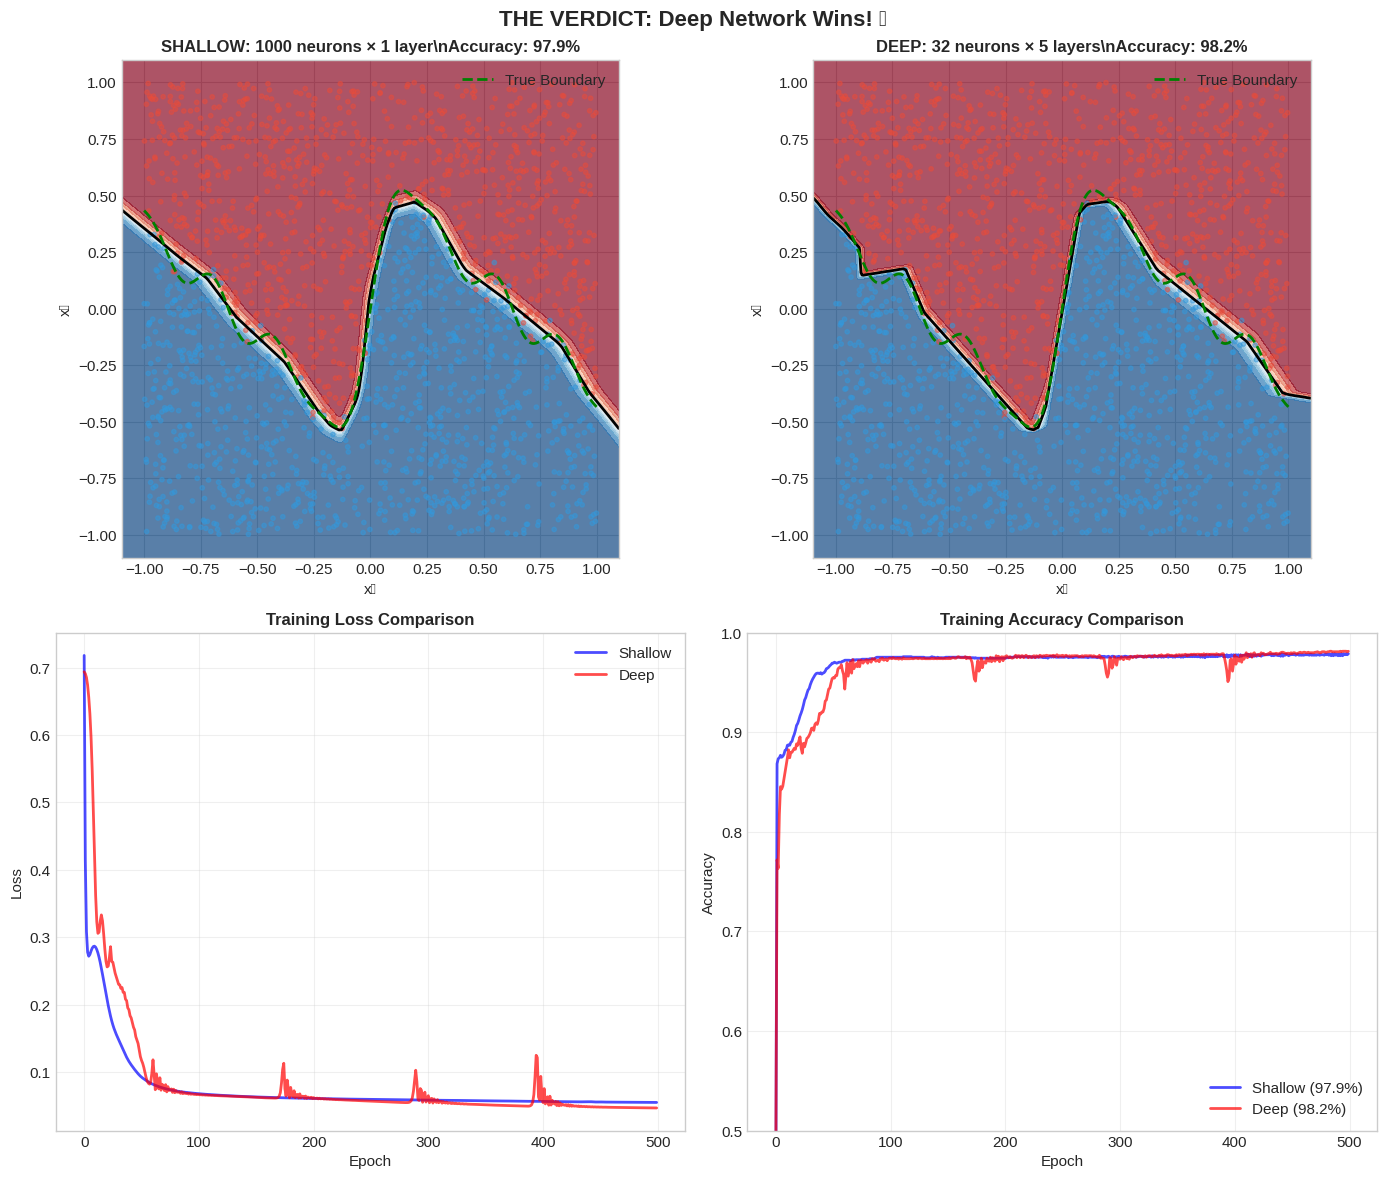

\n======================================================================
                         FINAL RESULTS
\n   SHALLOW (1000 neurons × 1 layer):
   • Parameters: 4,001
   • Final Accuracy: 97.9%
\n   DEEP (32 neurons × 5 layers):
   • Parameters: 4,353
   • Final Accuracy: 98.2%
\n======================================================================


In [ ]:
if TORCH_AVAILABLE:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Decision boundaries
    plot_decision_boundary(shallow_model, X_train, y_train,
                          f"SHALLOW: 1000 neurons × 1 layer\\nAccuracy: {shallow_accs[-1]*100:.1f}%",
                          axes[0, 0])

    plot_decision_boundary(deep_model, X_train, y_train,
                          f"DEEP: 32 neurons × 5 layers\\nAccuracy: {deep_accs[-1]*100:.1f}%",
                          axes[0, 1])

    # Training curves
    axes[1, 0].plot(shallow_losses, 'b-', label='Shallow', linewidth=2, alpha=0.7)
    axes[1, 0].plot(deep_losses, 'r-', label='Deep', linewidth=2, alpha=0.7)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(shallow_accs, 'b-', label=f'Shallow ({shallow_accs[-1]*100:.1f}%)', linewidth=2, alpha=0.7)
    axes[1, 1].plot(deep_accs, 'r-', label=f'Deep ({deep_accs[-1]*100:.1f}%)', linewidth=2, alpha=0.7)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Training Accuracy Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(0.5, 1.0)

    fig.suptitle('THE VERDICT: Deep Network Wins! 🏆', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\\n" + "="*70)
    print("                         FINAL RESULTS")
    print("="*70)
    print(f"\\n   SHALLOW (1000 neurons × 1 layer):")
    print(f"   • Parameters: {count_parameters(shallow_model):,}")
    print(f"   • Final Accuracy: {shallow_accs[-1]*100:.1f}%")
    print(f"\\n   DEEP (32 neurons × 5 layers):")
    print(f"   • Parameters: {count_parameters(deep_model):,}")
    print(f"   • Final Accuracy: {deep_accs[-1]*100:.1f}%")
    print("\\n" + "="*70)

---

# Summary: Why Deep Learning Works

## The Geometric Intuition

```
╔══════════════════════════════════════════════════════════════════════════════╗
║                    THE GEOMETRIC VIEW OF DEEP LEARNING                        ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                               ║
║  1. NEURONS FOLD SPACE                                                        ║
║     ───────────────────                                                       ║
║     Each ReLU neuron creates a "fold" or "bend" in the input space.          ║
║     This is like folding a piece of paper - you can create complex           ║
║     shapes by folding repeatedly!                                            ║
║                                                                               ║
║  2. WIDTH = LINEAR REGIONS                                                    ║
║     ────────────────────────                                                  ║
║     Adding neurons to one layer adds more folds, but they're all             ║
║     "parallel" - they don't compound on each other.                          ║
║     n neurons → ~n regions → LINEAR growth                                   ║
║                                                                               ║
║  3. DEPTH = EXPONENTIAL REGIONS                                               ║
║     ───────────────────────────                                               ║
║     Adding LAYERS lets folds compound on previous folds!                      ║
║     Each layer can double, triple, or more the number of regions.            ║
║     L layers with n neurons → up to n^L regions → EXPONENTIAL growth         ║
║                                                                               ║
║  4. TRAINING IS EASIER WITH DEPTH                                             ║
║     ─────────────────────────────                                             ║
║     Deep networks have better "gradient highways" that help learning.         ║
║     Shallow networks often get stuck in sub-optimal solutions.               ║
║                                                                               ║
╚══════════════════════════════════════════════════════════════════════════════╝
```

## Key Takeaways

```
    ┌────────────────────────────────────────────────────────────────────────┐
    │                         KEY TAKEAWAYS                                  │
    ├────────────────────────────────────────────────────────────────────────┤
    │                                                                        │
    │  ✅ The Universal Approximation Theorem promises that shallow          │
    │     networks CAN learn anything - but doesn't say it's EFFICIENT       │
    │                                                                        │
    │  ✅ Each ReLU neuron creates ONE fold in space                         │
    │                                                                        │
    │  ✅ Going DEEP creates hierarchical folds (folds of folds)            │
    │     that grow EXPONENTIALLY in complexity                              │
    │                                                                        │
    │  ✅ A deep network with 160 neurons can beat a shallow network         │
    │     with 100,000 neurons for complex patterns!                         │
    │                                                                        │
    │  ✅ This is why modern AI uses DEEP networks (GPT, ResNet, etc.)       │
    │                                                                        │
    └────────────────────────────────────────────────────────────────────────┘
```

## Visual Summary

```
                         SHALLOW                    DEEP
                         ═══════                    ════
                         
    Architecture:     [●●●●●●●●●●●]              [●●●●]
                           │                       │ │ │
                           ▼                      [●●●●]
                          [●]                      │ │ │
                                                  [●●●●]
                                                   │ │ │
                                                  [●●●●]
                                                   │ │ │
                                                   [●]
    
    Neurons:            1,000                      160
    Regions:            ~1,000                   ~100,000+
    Complexity:         LINEAR                  EXPONENTIAL
    Result:            STRUGGLES                 SUCCEEDS
```

---

## Congratulations! 🎉

You now understand **WHY** deep learning works at a fundamental, geometric level!

This insight - that depth creates exponentially more complex decision boundaries through hierarchical space folding - is one of the most important concepts in modern AI.

**Further Learning:**
- [Welch Labs YouTube Channel](https://www.youtube.com/user/Aborabia) - More great visualizations
- [Neural Networks: Zero to Hero](https://karpathy.ai/zero-to-hero.html) - Build neural networks from scratch
- Original "Attention Is All You Need" paper - How this led to Transformers

---

*Notebook based on the excellent Welch Labs video explaining why deep learning works.*